### Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p keras,tensorflow,numpy,pandas,matplotlib -g

Using TensorFlow backend.


Salomon Tetelepta 2019-07-15 08:30:03 

CPython 3.6.7
IPython 7.2.0

keras 2.2.4
tensorflow 1.11.0
numpy 1.16.2
pandas 0.23.4
matplotlib 2.0.2
Git hash:


### Imports

In [67]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

import logging
import cv2
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

### Settings

In [3]:
# path settings
project_path = Path(os.getcwd(), os.pardir)
data_path = project_path / "data"
output_path = project_path / "output"

In [71]:
# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import packages
from utils.identify import *
from utils.log import *
from dataset.dataset import *

logger = setup_logger(level=logging.INFO)

### Prepare dataset

In [7]:
dataset_path = data_path / "dataset" / "128x96"
csv_path = dataset_path.parent / "dataset.csv"

In [29]:
# save dataset meta-data to csv file
 prepare_dataset.create_metadata(dataset_path, csv_path)

2019-07-15 08:38:09,159 - INFO - :prepare_dataset - created dataframe with metadata
2019-07-15 08:38:09,236 - INFO - :prepare_dataset - saved dataframe with metadata to /Users/salomon/work/fink-projects/set-detection/notebooks/../data/dataset/dataset.csv


#### Check if dataset is setup correctly

In [143]:
# load meta data
df_dataset = pd.read_csv(csv_path)
df_dataset.head()

### >>> prepare dictionary id -> title, id -> output vector, output_vector -> id

,filename,variant,f_color,f_shape,f_fill,f_number,t_color,t_shape,t_fill,t_number,card_id
0,0_red_round_solid_one.jpg,0,red,round,solid,one,0,0,0,0,0
1,1_red_round_solid_one.jpg,1,red,round,solid,one,0,0,0,0,0
2,2_red_round_solid_one.jpg,2,red,round,solid,one,0,0,0,0,0
3,3_red_round_solid_one.jpg,3,red,round,solid,one,0,0,0,0,0
4,0_red_round_solid_two.jpg,0,red,round,solid,two,0,0,0,1,1


In [162]:
card_ids = df_dataset['card_id'].values
multilabels = df_dataset[['t_color', 't_shape', 't_fill', 't_number']].values
features = df_dataset[['f_color', 'f_shape', 'f_fill', 'f_number']].values

In [179]:
labels_dict = dict(zip(card_ids, multilabels))
features_dict = dict(zip(card_ids, features))

In [182]:
features_dict

{0: array(['red', 'round', 'solid', 'one'], dtype=object),
 1: array(['red', 'round', 'solid', 'two'], dtype=object),
 2: array(['red', 'round', 'solid', 'three'], dtype=object),
 3: array(['red', 'round', 'dotted', 'one'], dtype=object),
 4: array(['red', 'round', 'dotted', 'two'], dtype=object),
 5: array(['red', 'round', 'dotted', 'three'], dtype=object),
 6: array(['red', 'round', 'open', 'one'], dtype=object),
 7: array(['red', 'round', 'open', 'two'], dtype=object),
 8: array(['red', 'round', 'open', 'three'], dtype=object),
 9: array(['red', 'squiggle', 'solid', 'one'], dtype=object),
 10: array(['red', 'squiggle', 'solid', 'two'], dtype=object),
 11: array(['red', 'squiggle', 'solid', 'three'], dtype=object),
 12: array(['red', 'squiggle', 'dotted', 'one'], dtype=object),
 13: array(['red', 'squiggle', 'dotted', 'two'], dtype=object),
 14: array(['red', 'squiggle', 'dotted', 'three'], dtype=object),
 15: array(['red', 'squiggle', 'open', 'one'], dtype=object),
 16: array(['red'

#### Example: load data

In [95]:
aug_params = {
    "shear_range": 0.4,
    "zoom_range": 0.4,
    "horizontal_flip": True,
    "vertical_flip": True,    
    "rotation_range": 45
}

X, Y, _meta = load_dataset(dataset_path / "train", aug_params=aug_params, nr_images=162, output_path=output_path)

Found 243 images belonging to 81 classes.
(162, 81)


In [96]:
print(X.shape)
print(Y.shape)
print(_meta.shape)

(162, 96, 128, 3)
(162, 4)
(162,)


In [109]:
def get_sample(df, card_id, cols=['f_color', 'f_shape', 'f_fill', 'f_number', 't_color', 't_shape', 't_fill', 't_number']):
    return df[df.card_id==int(card_id)].drop_duplicates('card_id')[cols].values[0].astype(str)
    
def get_title(card_id):
    return "-".join(get_sample(df_dataset, card_id))

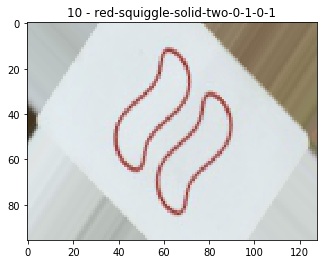

In [111]:
plt.title(f"{_meta[1]} - {get_title(_meta[1])}")
plt.imshow(X[0]/255)

In [133]:
X, target_ids = upsample_dataset(dataset_path / "train", nr_images=4, params=aug_params, target_size=(96, 128), batch_size=81, shuffle=True, output_path=output_path)

Found 243 images belonging to 81 classes.


In [139]:
target_ids

array(['16', '10', '54', '79'], dtype='<U2')

In [135]:
    _, target_feature_ids = get_class_info()

In [136]:
Y = get_multi_output_labels(target_ids, target_feature_ids)

In [137]:
Y

array([[0., 1., 2., 1.],
       [0., 1., 0., 1.],
       [2., 0., 0., 0.],
       [2., 2., 2., 1.]])

In [119]:
for i, yy in enumerate(Y):
    print(_meta[i], yy, get_title(_meta[i]))

16 [0. 1. 2. 1.] red-squiggle-open-two-0-1-2-1
10 [0. 1. 0. 1.] red-squiggle-solid-two-0-1-0-1
54 [2. 0. 0. 0.] purple-round-solid-one-2-0-0-0
79 [2. 2. 2. 1.] purple-square-open-two-2-2-2-1
80 [2. 2. 2. 2.] purple-square-open-three-2-2-2-2
61 [2. 0. 2. 1.] purple-round-open-two-2-0-2-1
73 [2. 2. 0. 1.] purple-square-solid-two-2-2-0-1
54 [2. 0. 0. 0.] purple-round-solid-one-2-0-0-0
11 [0. 1. 0. 2.] red-squiggle-solid-three-0-1-0-2
42 [1. 1. 2. 0.] green-squiggle-open-one-1-1-2-0
22 [0. 2. 1. 1.] red-square-dotted-two-0-2-1-1
71 [2. 1. 2. 2.] purple-squiggle-open-three-2-1-2-2
77 [2. 2. 1. 2.] purple-square-dotted-three-2-2-1-2
6 [0. 0. 2. 0.] red-round-open-one-0-0-2-0
33 [1. 0. 2. 0.] green-round-open-one-1-0-2-0
57 [2. 0. 1. 0.] purple-round-dotted-one-2-0-1-0
8 [0. 0. 2. 2.] red-round-open-three-0-0-2-2
13 [0. 1. 1. 1.] red-squiggle-dotted-two-0-1-1-1
29 [1. 0. 0. 2.] green-round-solid-three-1-0-0-2
47 [1. 2. 0. 2.] green-square-solid-three-1-2-0-2
19 [0. 2. 0. 1.] red-square-solid-